In [ ]:
!pip install -q -U "tensorflow-text==2.9.*"

     |████████████████████████████████| 4.6 MB 5.3 MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.2 MB 5.0 MB/s 
     |████████████████████████████████| 5.9 MB 31.9 MB/s 
     |████████████████████████████████| 352 kB 70.2 MB/s 
     |████████████████████████████████| 636 kB 61.5 MB/s 
     |████████████████████████████████| 1.1 MB 63.4 MB/s 
     |████████████████████████████████| 116 kB 63.0 MB/s 
     |████████████████████████████████| 238 kB 67.6 MB/s 
     |████████████████████████████████| 1.3 MB 62.5 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 1.7 MB 50.5 MB/s 
     |████████████████████████████████| 5.9 MB 50.1 MB/s 
     |████████████████████████████████| 438 kB 64.2 MB/s 


In [ ]:
pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.18.0
    Uninstalling tensorflow-addons-0.18.0:
      Successfully uninstalled tensorflow-addons-0.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Seq2Seq Recurrent Translation
In questo esercizio verranno usate coppie di frasi, di cui una in inglese ed una in italiano,
prese dal "Progetto Tatoeba" (https://tatoeba.org/it/) dove diversi utenti
contribuiscono continuamente nel fornire esempi di traduzioni.
Con questo dataset sarà possibile addestrare un modello Seq2Seq basato su un Encoder-Decoder ricorrente per
implementare un traduttore automatico.

In [ ]:
# importazione librerie necessarie
import os
import time
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
import tensorflow_models as tfm
from keras import backend as K
from keras import layers
from official.nlp import optimization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
tf.config.run_functions_eagerly(True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.10.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
# parametri globali
root_folder='drive/MyDrive/BERT/'
data_folder_name='data'
train_filename='ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# sia i dati di addestramento che quelli di
# test si trovano nella stessa cartella
train_path = DATA_PATH
test_path = DATA_PATH

# PATH LOG Tensorboard
PATH_LOG = "logs/fit/"
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

In [ ]:
# parametri globali
data_folder_vocab='vocab'
custom_vocab='custom_vocab.txt'

DATA_PATH_VOCAB = os.path.abspath(os.path.join(root_folder, data_folder_vocab))
vocab_filenamepath = os.path.abspath(os.path.join(DATA_PATH_VOCAB, custom_vocab))

In [ ]:
# os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  
tfhub_handle_encoder =  'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print('BERT model selected                : ', tfhub_handle_encoder)
print('Preprocessing model auto-selected  : ', tfhub_handle_preprocess)

BERT model selected                :  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected  :  https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 10000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
EPOCHS = 50
max_seq_length = 16

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    '''
    Preprocessing dei testi di input, impostando tutti i caratteri
    minuscoli, aggiungendo uno spazio prima di ogni punto e sostituendo
    qualsiasi carattere con uno spazio se non è compreso nel seguente elenco:
    (a-z, A-Z, ".", "?", "!", ",")
    '''
    w = unicode_to_ascii(w.lower().strip())

    # inserimento di uno spazio tra ogni parola e il successivo punto,
    # punto esclamativo, punto interrogativo e virgola
    # esempio: "ciao, come và?" => "ciao , come và ?"
    w = re.sub(r"([?.!,])", r" \1 ", w) # inserimento di uno spazio

    # sostituzione dei caratteri non desiderati con uno spazio
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

    w = re.sub(r'[" "]+', " ", w) # rimozione di più spazi consecutivi
    return w

### Caricamento del Dataset
Caricamento del dataset in un DataFrame Pandas e applicazione delle funzioni
di preprocessing sullo stesso nelle colonne di Input e Target

In [ ]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

print(df.iloc[42:52], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data_eos = df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()

# Preprocessing dei dati Target con aggiunta del token di inizio frase
target_data_sos = df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data_eos[:5])
print(target_data_sos[:5])

     input          target
42  Do it.      Lo faccia.
43  Do it.      La faccia.
44  Do it.         Fatelo.
45  Do it.         Fatela.
46  Go on.     Vai avanti.
47  Go on.       Continua.
48  Go on.       Continui.
49  Go on.     Continuate.
50  Go on.    Vada avanti.
51  Go on.  Andate avanti. 

['hi . ', 'hi . ', 'run ! ', 'run ! ', 'run ! ']
['ciao !  <eos>', 'ciao .  <eos>', 'corri !  <eos>', 'corra !  <eos>', 'correte !  <eos>']
['<sos> ciao ! ', '<sos> ciao . ', '<sos> corri ! ', '<sos> corra ! ', '<sos> correte ! ']


### Vocabolario

In [ ]:
bert_tokenizer_params=dict(lower_case=True)
# reserved_tokens=["CLS"]
reserved_tokens = {
    'start_of_sequence_id': 101,
    'end_of_segment_id': 102,
    'padding_id': 0,
    'mask_id': 103
}

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = MAX_VOCAB_SIZE,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
custom_vocab1 = bert_vocab.bert_vocab_from_dataset(
    tf.data.Dataset.from_tensor_slices(input_data),
    **bert_vocab_args
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
write_vocab_file(vocab_filenamepath, custom_vocab)

In [ ]:
DATA_PATH_VOCAB

'/content/drive/MyDrive/BERT/vocab'

In [ ]:
!ls /content/drive/MyDrive/BERT/vocab

bert-it-vocab.txt    custom_vocab.txt  it_vocab.txt
custom-it-vocab.txt  en_vocab.txt


### Tokenizzazione
La conversione di sequenze di parole in sequenze di numeri interi permette ai modelli
di operare su testi.
In questo esempio vengono utilizzati due tokenizzatori, sfruttando l'oggetto Tokenizer di Keras,
uno per le sequenze di input e uno per quelle di target.

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"

input_tokenizer = text.BertTokenizer(os.path.join(gs_folder_bert, "vocab.txt"),
                                     lower_case=True)

# Tokenize the examples 
token_examples = input_tokenizer.tokenize(input_data[42])
# Merge the word and word-piece axes -> (batch, tokens)
token_examples = token_examples.merge_dims(-2,-1)

print(input_data[42])

for ex in token_examples.to_list():
  print(ex)

do it . 
[2079, 2009, 1012]


In [ ]:
bert_vocab_args["reserved_tokens"]

{'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [ ]:
packer_input = tfm.nlp.layers.BertPackInputs(
  seq_length=max_seq_length,
  special_tokens_dict=bert_vocab_args["reserved_tokens"])

In [ ]:
packer_input([token_examples])

{'input_word_ids': <tf.Tensor: shape=(1, 16), dtype=int64, numpy=
 array([[ 101, 2079, 2009, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]])>,
 'input_mask': <tf.Tensor: shape=(1, 16), dtype=int64, numpy=array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>,
 'input_type_ids': <tf.Tensor: shape=(1, 16), dtype=int64, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>}

In [ ]:
class Bert_Pre_Process(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super(Bert_Pre_Process, self).__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, input_sequence):
    token = self.tokenizer.tokenize(input_sequence)
    token = token.merge_dims(-2,-1)

    token = packer_input(token)
    return token

In [ ]:
preprocess = Bert_Pre_Process(input_tokenizer, packer_input)

# Esempio di sequenza di parole trasformata in sequenza di numeri
print(input_data[42])
preprocess(input_data[42])

do it . 


{'input_word_ids': <tf.Tensor: shape=(1, 16), dtype=int64, numpy=
 array([[ 101, 2079, 2009, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]])>,
 'input_mask': <tf.Tensor: shape=(1, 16), dtype=int64, numpy=array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>,
 'input_type_ids': <tf.Tensor: shape=(1, 16), dtype=int64, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>}

In [ ]:
# Tokenizzazione dei target
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data_eos)
tokenizer_outputs.fit_on_texts(target_data_sos)

# trasformazione dei testi in sequenze di interi
target_sequences_eos = tokenizer_outputs.texts_to_sequences(target_data_eos)
target_sequences_sos = tokenizer_outputs.texts_to_sequences(target_data_sos)

# lunghezza massima delle sequenze di target
target_eos_max_len = max(len(s) for s in target_sequences_eos)
print('Max Target Length: ', target_eos_max_len, '\n')

print('Frase target con eos:', target_data_eos[42])
print('Sequenza target con eos:', target_sequences_eos[42])
print('Frase target con sos:', target_data_sos[42])
print('Sequenza target con sos:', target_sequences_sos[42])

Max Target Length:  10 

Frase target con eos: lo faccia .  <eos>
Sequenza target con eos: [18, 71, 1, 2]
Frase target con sos: <sos> lo faccia . 
Sequenza target con sos: [3, 18, 71, 1]


### Creazione dei vocabolari
Dai tokenizer creati precedentemente possiamo ricavare i relativi vocabolari
per poter far corrispondere una parola ad un indice (word2idx) e per far
corrispondere un indice ad una parola (idx2word)

In [ ]:
# recupero dell'indice delle parole per il vocabolario di output
word2idx_outputs = tokenizer_outputs.word_index
print('Trovati %s token di output unici.' % len(word2idx_outputs))

# strutture dati per recuperare una particolare
# parola partendo dal suo indice
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Trovati 3638 token di output unici.


### Padding delle frasi
Aggiunta di valori nulli (zero) alla fine di ogni frase per rendere tutte le frasi della
stessa lunghezza. Alternativamente non sarebbe possibile addestrare il modello su più
esempi per volta (batch training)

In [ ]:
# padding delle frasi target con sos
decoder_inputs = pad_sequences(target_sequences_sos, maxlen=target_eos_max_len, padding='post')
print("sequenza target con <sos>", target_sequences_sos[42])
print("decoder_inputs[0]:", decoder_inputs[42])
print("decoder_inputs.shape:", decoder_inputs.shape)
print('')

# padding delle frasi target con eos
decoder_targets = pad_sequences(target_sequences_eos, maxlen=target_eos_max_len, padding='post')
print("sequenza target con <eos>", target_sequences_eos[42])
print("decoder_target[0]:", decoder_targets[42])
print("decoder_target.shape:", decoder_targets.shape)

sequenza target con <sos> [3, 18, 71, 1]
decoder_inputs[0]: [ 3 18 71  1  0  0  0  0  0  0]
decoder_inputs.shape: (10000, 10)

sequenza target con <eos> [18, 71, 1, 2]
decoder_target[0]: [18 71  1  2  0  0  0  0  0  0]
decoder_target.shape: (10000, 10)


### Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [ ]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
dataset = tf.data.Dataset.from_tensor_slices((input_data, decoder_inputs, decoder_targets))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

### Implementazione di un modelo Encoder-Decoder ricorrente
Il modello può essere rappresentato tramite i suoi tre principali componenti: encoder, vettore codificato, decoder:
     
![encoder decoder](img/encoder_decoder_RNN_lowres.jpg)    
    
* **encoder**: basato su un layer ricorrente, che riceve una parola della sequenza di input sotto forma di token numerico per ogni istante temporale, producendo un output ed uno stato per ogni istante temporale. Lo stato ad ogni momento t viene utilizzato nell'istante t+1 insieme all'input relativo all'istante t+1.
* **encoder vector**: è lo stato prodotto in output dai layer ricorrenti dopo aver processato l'intera sequenza di input. La rete, durante l'addestramento, farà in modo da far produrre le migliori informazioni possibili in modo che il blocco di decoder successivo possa effettuare al meglio il suo lavoro. 
* **decoder**: basato su un layer ricorrente come il blocco di encoder. Prende in input l'encoder vector e produce l'output che rappresenta la probabilità corrispondente ad ogni token del vocabolario.

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_dim, bert_encoder, bert_preprocess, max_seq_length):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.max_seq_length = max_seq_length
        self.preprocess = hub.load(bert_preprocess)
        # self.encoder = hub.load(bert_encoder)
        self.encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')
        self.lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True, name='encoder_lstm1')

    def call(self, input_sequence, states):
        sequence = self.preprocess.tokenize(input_sequence)
        encoder_inputs = self.preprocess.bert_pack_inputs([sequence], seq_length=self.max_seq_length)
        
        encoder_outputs = self.encoder(encoder_inputs)['sequence_output'] # pooled_output?????????
        
        output, state_h, state_c = self.lstm(encoder_outputs, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # inizializzazione dello stato per le celle ricorrenti
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, name='decoder_embedding')
        self.lstm = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True, name='decoder_lstm1')
        self.dense = tf.keras.layers.Dense(vocab_size, name='decoder_dense')

    def call(self, input_sequence, state):
        embed = self.embedding(input_sequence)
        lstm_out, state_h, state_c = self.lstm(embed, state)
        logits = self.dense(lstm_out)
        return logits, state_h, state_c

Di seguito vengono istanziati un encoder e un decoder e vengono testate le funzionalità:

In [ ]:
encoder = Encoder(EMBEDDING_DIM, HIDDEN_DIM, tfhub_handle_encoder, tfhub_handle_preprocess, max_seq_length)
initial_state = encoder.init_states(2)

# chiamata all'encoder per testing
test_encoder_output, state_h, state_c = encoder([input_data[42], input_data[1]], initial_state)
print(test_encoder_output.shape)

num_words_output = len(word2idx_outputs) + 1

decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
de_initial_state = [state_h, state_c]

# chiamata al decoder per testing
test_decoder_output = decoder(tf.constant([decoder_inputs[42], decoder_inputs[1]]), de_initial_state)
print(test_decoder_output[0].shape)

(2, 16, 1024)
(2, 10, 3639)


### Funzione di costo e metriche
Definizione di una funzione di costo custom per evitare di considerare i valori 0 usati nel padding quando viene calcolato l'errore.
Discorso analogo per il calcolo dell'accuratezza del modello.

In [ ]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # mascheramento dei valori uguali a 0, usati per il padding
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # calcolo dell'errore
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

def accuracy_fn(y_true, y_pred):
    # dimensioni y_pred: (batch_size, seq_length, vocab_size)
    # dimensioni y_true: (batch_size, seq_length)
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # mascheramento dei valori uguali a 0, usati per il padding
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

### Addestramento

* Chiamata all'encoder per ogni batch di sequenze di input, l'output prodotto è il vettore encoded
* Impostazione dello stato iniziale del decoder uguale al vettore encoded
* Chiamata al decoder, passando in input la sequenza target presa dal secondo elemento per eliminare il token <sos>
* Calcolo del loss e dell'accuracy per ogni batch di esempi
* Aggiornamento dei parametri del modello

In [ ]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    # tf.print(f'Eager mode       : {tf.executing_eagerly()}')
    
    # usiamo tf.GradientTape per tenere traccia dei gradienti
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        
        # configurazione dello stato del decoder basato sull'output dell'encoder
        en_states = en_outputs[1:]
        de_states = en_states

        de_outputs = decoder(target_seq_in, de_states)

        # logits dell'output
        logits = de_outputs[0]

        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    parameters = encoder.trainable_variables + decoder.trainable_variables
    
    res = []
    for p in parameters:
      '''
      tf.print("**************************")
      tf.print(f"p         : {p}")
      tf.print(f"p         : {p.shape}")
      tf.print(f"p.name    : {p.name}")
      tf.print("**************************")
      '''
      res.append([p.name, p.numpy()])

    # tf.print("____________________________________")
    # tf.print(f"res {res}")
    # calcolo dei gradienti sui parametri del modello
    gradients = tape.gradient(loss, parameters)

    # correzione dei pesi del modello
    optimizer.apply_gradients(zip(gradients, parameters))
   
    return loss, acc, res

Per l'addestramento vengono usate tre sequenze:

* **Input sequence**: array di interi di dimensione (batch_size, max_seq_len, embedding dim). E' la sequenza di input all'encoder

* **target sequence**: array di interi di dimensione (batch_size, max_seq_len, embedding dim). E' l'output aspettato dal modello

* **Target input sequence**: array di interi di dimensione (batch_size, max_seq_len, embedding dim). Sequenza di input al decoder che sfrutta il metodo *Teacher Forcing*
    
        
        
### Teacher Forcing
*Teacher Forcing* è uno dei principali metodi di addestramento in ambito NLP.
E' un modo per addestrare velocemente un'architettura ricorrente.
Normalmente, in architetture ricorrenti, l'input al momento t di una sequenza è l'output
generato dallo stesso modello all'istante t-1.
Al posto dell'output generato dal modello, si usa l'output previsto al momento t-1
come input per ogni momento successivo t. In questo modo è possibile migliorare le capacità
di apprendimento della rete.

Questa tecnica di addestramento è altamente performante quando l'output previsto da un modello non
varia eccessivamente durante l'addestramento. Se si necessita di un modello che sia più creativo e
meno conservativo, questa tecnica non dovrebbe essere utilizzata oppure dovrebbe essere utilizzata
ogni tot step generativi, in modo pseudocasuale, come contributo ad una varianza negli output.

In [ ]:
# metodo per avviare un addestramento
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    tf.keras.callbacks.TensorBoard(log_dir)
    log_writer = tf.summary.create_file_writer(logdir=log_dir)

    for e in range(n_epochs):
        start = time.time()
        # inizializzazione e recupero dello stato inizializzato dell'encoder
        en_initial_states = encoder.init_states(batch_size)

        # ciclo su tutti gli esempi un batch alla volta
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
          batch_loss = tf.keras.metrics.Mean()

          # addestramento e recupero metriche
          loss, accuracy, res = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
          
          batch_loss(loss)
          
          if batch % 100 == 0:
            # memorizzazione loss e accuracy ogni 100 batch per analisi successive  
            losses.append(loss)
            accuracies.append(accuracy)
            
            with log_writer.as_default():
              tf.summary.scalar('batch_loss', batch_loss.result(), step=optimizer.iterations)
              tf.summary.scalar('batch_accuracy', accuracy, step=optimizer.iterations)
              for p in res:
                tf.summary.histogram(p[0], p[1], step=optimizer.iterations)
            
            print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
            # break    
        
        # checkpoint (salvataggio stato) del modello ogni 2 epoche
        # data la lentezza dell'addestramento, permette di recuperarne
        # lo stato in momenti successivi ad un qualsiasi stop per poter
        # continuare l'addestramento senza riavviarlo dal principio
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
        print('Tempo necessario per un\'epoca {:.4f} sec\n'.format(time.time() - start))

    return losses, accuracies

In [ ]:
# impostazione di Adam come ottimizzatore con il parametro [clipnorm] impostato
# a 5 per abilitare una regolarizzazione L2 dei gradienti nel momento in cui la
# loro media supera questo valore - limita eventuali fenomeni di esplosione del
# gradiente e frena una modifica radicale dei pesi, permettendo una migliore
# generalizzazione
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)

# creazione di un primo checkpoint del modello appena creato

checkpoint_dir = 'weights/seq2seq'
checkpoint_dir = os.path.abspath(os.path.join(root_folder, checkpoint_dir))
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
start = datetime.datetime.now()
# avvio dell'addestramento con gli iperparametri settati precedentemente
losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)
end = datetime.datetime.now()
print(f"Tempo necessario per l'addestramento: {end - start}")

Epoch 1 Batch 0 Loss 3.7896 Acc:0.0000
Epoch 1 Batch 100 Loss 1.5308 Acc:0.5479
Epoch 1 Batch 200 Loss 1.4350 Acc:0.5260
Epoch 1 Batch 300 Loss 1.2395 Acc:0.5600
Tempo necessario per un'epoca 100.7904 sec

Epoch 2 Batch 0 Loss 1.0716 Acc:0.5667
Epoch 2 Batch 100 Loss 1.0898 Acc:0.5833
Epoch 2 Batch 200 Loss 0.7627 Acc:0.6713
Epoch 2 Batch 300 Loss 0.7291 Acc:0.6383
Tempo necessario per un'epoca 90.2919 sec

Epoch 3 Batch 0 Loss 0.5795 Acc:0.7279
Epoch 3 Batch 100 Loss 0.5905 Acc:0.7237
Epoch 3 Batch 200 Loss 0.6153 Acc:0.6863
Epoch 3 Batch 300 Loss 0.5252 Acc:0.6643
Tempo necessario per un'epoca 90.8833 sec

Epoch 4 Batch 0 Loss 0.3783 Acc:0.7823
Epoch 4 Batch 100 Loss 0.3995 Acc:0.7651
Epoch 4 Batch 200 Loss 0.3502 Acc:0.7730
Epoch 4 Batch 300 Loss 0.4549 Acc:0.7020
Tempo necessario per un'epoca 90.7230 sec

Epoch 5 Batch 0 Loss 0.3141 Acc:0.7724
Epoch 5 Batch 100 Loss 0.3093 Acc:0.7895
Epoch 5 Batch 200 Loss 0.4309 Acc:0.7342
Epoch 5 Batch 300 Loss 0.3330 Acc:0.7778
Tempo necessario 

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

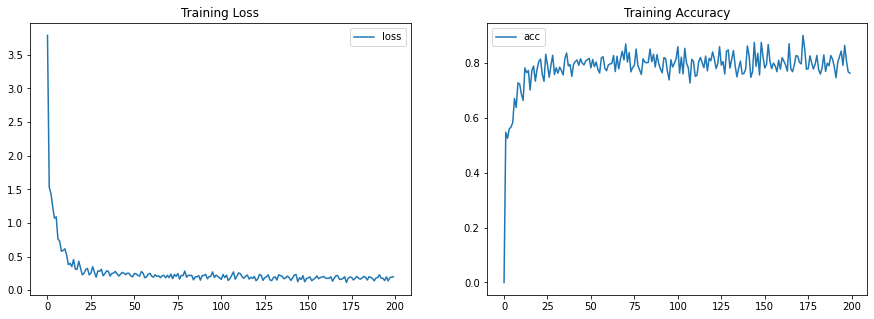

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

### Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# caricamento dell'ultimo checkpoint disponibile
checkpoint_dir = 'weights/seq2seq'
checkpoint_dir = os.path.abspath(os.path.join(root_folder, checkpoint_dir))

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Per effettuare una predizione, si deve fornire una sequenza di lunghezza 1
contenente il token sos (start-of-sentence), quindi è posisbile chiamare
l'encoder e il decoder ripetutamente finché non si riceve il token eos
(end-of-sentence) o non si raggiunge il limite massimo di lunghezza.

In [ ]:
# def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
def predict(input_text, encoder, input_max_len, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
        print(input_text)

    # inizializzazione stati encoder
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder([input_text], en_initial_states)
    # creazione dell'input al decoder, tramite il token <start-of-sentence>
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    print('1', de_input)

    # impostazione degli stati dell'encoder agli stati in output dall'encoder
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # decodifica e recupero probabilità di output
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        
        print('2', tf.argmax(de_output, -1))
        # selezione della parola più probabile
        de_input = tf.argmax(de_output, -1)
        # inserimento della parola nella sequenza di output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        print('3', out_words)
        # termine del ciclo quando si incontra il token <end-of-sentence>
        # oppure la lunghezza massima prevista della sequenza
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))

Test del modello tramite qualche esempio preso dal dataset di addestramento

In [ ]:
test_sequences = [input_data[41], input_data[102], input_data[612], input_data[432], input_data[222]]

for test_sequence in test_sequences:
    print(test_sequence)
    predict(test_sequence, encoder, max_seq_length, word2idx_outputs, idx2word_outputs)
    print('  -----------------  ')

do it . 
1 tf.Tensor([[3]], shape=(1, 1), dtype=int32)
2 tf.Tensor([[268]], shape=(1, 1), dtype=int64)
3 ['fatelo']
2 tf.Tensor([[1]], shape=(1, 1), dtype=int64)
3 ['fatelo', '.']
2 tf.Tensor([[2]], shape=(1, 1), dtype=int64)
3 ['fatelo', '.', '<eos>']
fatelo . <eos>
  -----------------  
go now . 
1 tf.Tensor([[3]], shape=(1, 1), dtype=int32)
2 tf.Tensor([[73]], shape=(1, 1), dtype=int64)
3 ['vai']
2 tf.Tensor([[42]], shape=(1, 1), dtype=int64)
3 ['vai', 'adesso']
2 tf.Tensor([[1]], shape=(1, 1), dtype=int64)
3 ['vai', 'adesso', '.']
2 tf.Tensor([[2]], shape=(1, 1), dtype=int64)
3 ['vai', 'adesso', '.', '<eos>']
vai adesso . <eos>
  -----------------  
cool off ! 
1 tf.Tensor([[3]], shape=(1, 1), dtype=int32)
2 tf.Tensor([[19]], shape=(1, 1), dtype=int64)
3 ['si']
2 tf.Tensor([[316]], shape=(1, 1), dtype=int64)
3 ['si', 'calmi']
2 tf.Tensor([[9]], shape=(1, 1), dtype=int64)
3 ['si', 'calmi', '!']
2 tf.Tensor([[2]], shape=(1, 1), dtype=int64)
3 ['si', 'calmi', '!', '<eos>']
si calmi ! 

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

'/content/drive/MyDrive/BERT/logs/fit/20221028-094634'

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221028-094634